In [1]:
import os
import sys
# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline

print(sys.executable)
print(f"CUDA available: {torch.cuda.is_available()}")

d:\VSCode\test-chronos-2\.venv\Scripts\python.exe
CUDA available: True


In [2]:
# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [3]:
# Energy price forecasting configuration
target = "target"       # Column name containing the values to forecast (energy prices)
prediction_length = 24  # Number of hours to forecast ahead
id_column = "id"        # Column identifying different time series (countries/regions)
timestamp_column = "timestamp" # Column containing datetime information
timeseries_id = "DE"    # Specific times series to visualize (Germany)
batch_size = 100

## **Forecasting with Covariates**
Chronos-2 can leverage covariates to improve forecast accuracy. We demonstrate this with two real-world examples.

### **Energy Price Forecasting**
Forecast hourly energy prices for the next day using historical prices and day-ahead forecasts of load (Ampirion Load Forecast) and renewable energy generation (PV+Wind Forecast).

In [5]:
# Load historical energy prices and past values of covariates
energy_context_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet")
energy_context_df[timestamp_column] = pd.to_datetime(energy_context_df[timestamp_column])

# Load future values of covariates
energy_test_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet")
energy_test_df[timestamp_column] = pd.to_datetime(energy_test_df[timestamp_column])

energy_future_df = energy_test_df.drop(columns=target)

display(energy_context_df.head())
display(energy_future_df.head())

,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902


,id,timestamp,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2017-12-12 00:00:00,20483.00,22284.005859
1,DE,2017-12-12 01:00:00,19849.75,22878.673828
2,DE,2017-12-12 02:00:00,19638.25,23632.283203
3,DE,2017-12-12 03:00:00,19895.25,24635.945312
4,DE,2017-12-12 04:00:00,20338.00,25584.935547


`predict_df` supports the following arguments:
- `df`: Long-format DataFrame with id, timestamp, and target column(s)
- `future_df`: Optional DataFrame with future covariates (columns present in both df and future_df are treated as known future covariates)
- `id_column`: Column with time series identifiers (default: "item_id")
- `timestamp_column`: Column with timestamps (default: "timestamp")
- `target`: Target column name(s) to forecast (default: "target")
- `prediction_length`: Number of steps to forecast
- `quantile_levels`: Quantiles to compute (default: [0.1, 0.2, ..., 0.9])
Returns a DataFrame with forecasts including point predictions and quantiles.

In [6]:
# Generate predictions with covariates
energy_pred_df = pipeline.predict_df(
    energy_context_df,
    future_df=energy_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target
)

# Compare with forecast without covariates
energy_pred_no_cov_df = pipeline.predict_df(
    energy_context_df[[id_column, timestamp_column, target]],
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
# Cross-learning enabled for joint prediction
# This assigns the same group ID to all time series, allowing information sharing
joint_pred_df = pipeline.predict_df(
    energy_context_df,
    future_df=energy_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
    cross_learning=True,
    batch_size=batch_size,
)

display(energy_pred_df.head())
display(energy_pred_no_cov_df.head())
display(joint_pred_df.head())

,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,22.242920,18.673723,22.242920,25.403450
1,DE,2017-12-12 01:00:00,target,19.525620,14.904274,19.525620,23.316597
2,DE,2017-12-12 02:00:00,target,17.415371,12.209051,17.415371,21.776978
3,DE,2017-12-12 03:00:00,target,16.979265,11.165123,16.979265,21.435226
4,DE,2017-12-12 04:00:00,target,18.058655,12.096773,18.058655,23.166645


,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,26.223289,22.333860,26.223289,29.256596
1,DE,2017-12-12 01:00:00,target,24.404884,18.494837,24.404884,28.712910
2,DE,2017-12-12 02:00:00,target,23.736683,16.602047,23.736683,29.478062
3,DE,2017-12-12 03:00:00,target,23.953293,16.416323,23.953293,30.183331
4,DE,2017-12-12 04:00:00,target,25.516411,17.441809,25.516411,31.773947


,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,DE,2017-12-12 00:00:00,target,22.242920,18.673723,22.242920,25.403450
1,DE,2017-12-12 01:00:00,target,19.525620,14.904274,19.525620,23.316597
2,DE,2017-12-12 02:00:00,target,17.415371,12.209051,17.415371,21.776978
3,DE,2017-12-12 03:00:00,target,16.979265,11.165123,16.979265,21.435226
4,DE,2017-12-12 04:00:00,target,18.058655,12.096773,18.058655,23.166645


### **Cross-Learning with Joint Prediction**

Chronos-2 supports **cross-learning** through the `cross_learning=True` parameter, which enables the model to share information across all time series in a batch during prediction. This can be particularly beneficial when forecasting multiple related time series with short historical context.

**Important Considerations for Cross-Learning**

When using cross_learning=True, keep these caveats in mind:
- **Task-dependent results**: Cross-learning may not always improve forecasts and could worsen performance for some tasks. Evaluate this feature for your specific use case.
- **Batch size dependency**: Results become dependent on batch size. Very large batch sizes may not provide benefits as they deviate from the maximum group size used during pretraining. For optimal results, consider using a batch size around 100 (as used in the paper).
- **Input homogeneity**: This feature works best with homogeneous inputs (e.g., multiple univariate time series of the same type). Mixing different task types may lead to unexpected behavior.
- **Short context benefit**: Cross-learning is most helpful when individual time series have limited historical context, as the model can leverage patterns from related series in the batch.

In [7]:
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
        )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    #fig.show()
    plt.show()

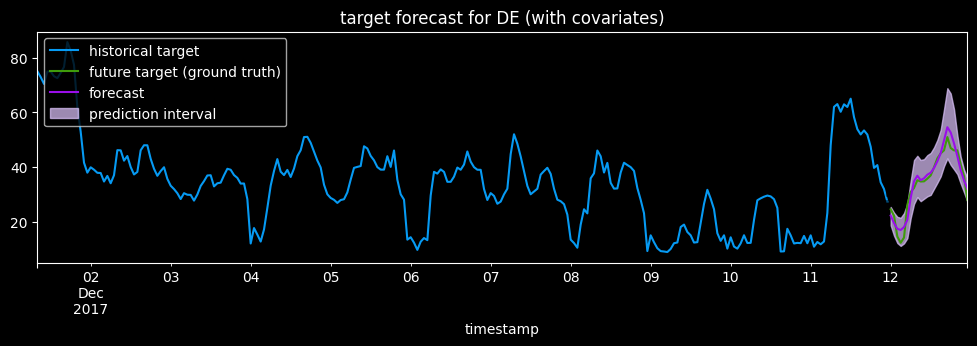

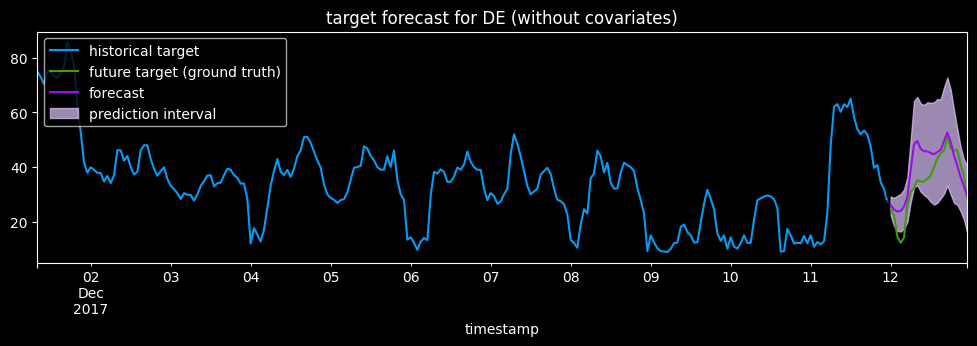

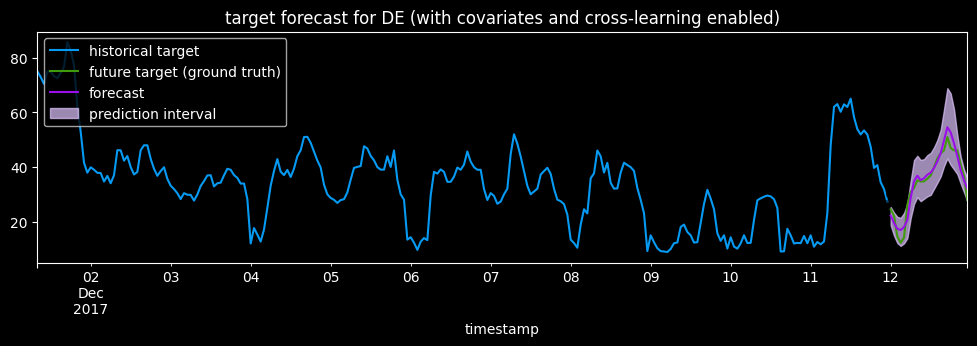

In [8]:
# Visualize forecast with covariates
plot_forecast(
    energy_context_df,
    energy_pred_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates)",
)
plot_forecast(
    energy_context_df,
    energy_pred_no_cov_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(without covariates)",
)
plot_forecast(
    energy_context_df,
    joint_pred_df,
    energy_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    title_suffix="(with covariates and cross-learning enabled)",
)